In [5]:
%matplotlib inline

# Hybrid Images

The objective of this exercise is to create a hybrid image by combining a low-pass filtered image with a high-pass filtered one. The resulting image will display the low-pass image when viewed from a distance, while the high-pass image will be visible up close. We will achieve this result in two different ways: in the first exercise, the images will be fused in the spatial domain using a Gaussian filter; in the second exercise, the fusion will occur in the frequency domain using the Fourier transform.

In [6]:
# All necessary imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from scipy import signal, fftpack

We begin by editing the necessary images to ensure that the image fusion is done properly. The cat and human images are manually aligned at the facial area, using the eyes and mouth as key reference points.

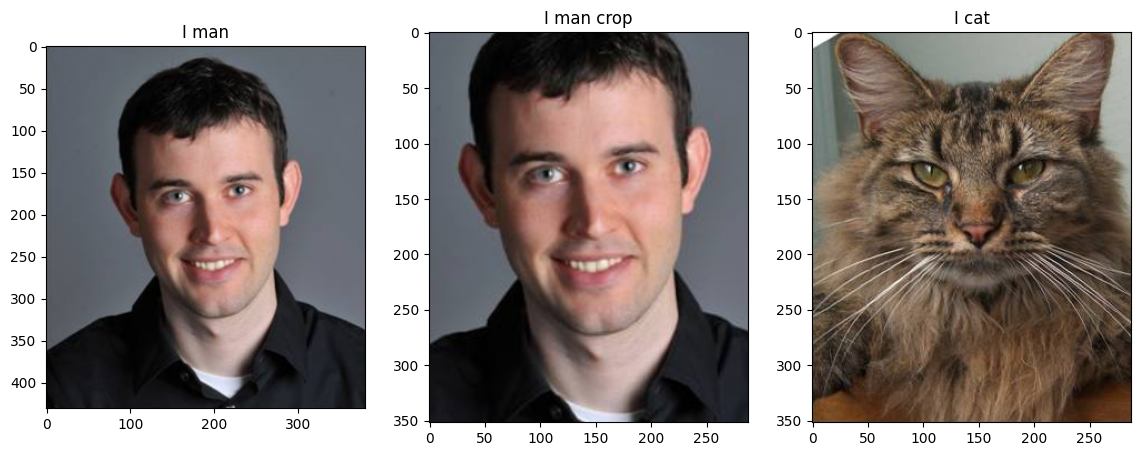

In [7]:
# LOAD IMAGES
human = io.imread('human.png')
cat = io.imread('cat.png')

## RESIZE
size1=int(round(human.shape[0]*(4/3.)))
size2=int(round(human.shape[1]*(4/3.)))
human = transform.resize(human,(size1, size2))

# CROP
left = 50
top = 50
right = 51+cat.shape[0]-1
bottom = 51+cat.shape[1]-1
human_c = human[left: right, top:bottom]

# VISUALIZATION ---------------
plt.figure(1)

plt.subplot(131)
plt.imshow(human,cmap="gray")
plt.title('I man')

plt.subplot(132)
plt.title('I man crop')
plt.imshow(human_c,cmap="gray")

plt.subplot(133)
plt.title('I cat')
plt.imshow(cat,cmap="gray")

plt.gcf().set_size_inches((14,14))

Since obtaining the high-pass and hybrid images is a repeated process, I created the function below to streamline it. This function takes three parameters: the low-pass image and the original image from which we want to extract the high-pass image, and the other low-pass image to create the hybrid image.

To find the high-pass image, we can either apply an inverted Gaussian filter to the original image, following a similar procedure to that of the low-pass image, or we can take a simpler approach: subtract the low-pass image from the original image. This subtraction effectively removes the general form of the image, leaving only the details that constitute the high-pass image.

Finally, the hybrid image can be achieved by simply summing the low-pass human image with the HP cat image

In [8]:
def HP_HybridImage(lp_img1, original_img1, lp_img2):
    # FIND HIGH PASS IMAGE
    hp_img = original_img1 - lp_img1
    hp_img = np.clip(hp_img, 0, 1)

    # FUSE HP AND LP TO GET HYBRID
    hybrid = lp_img2 + hp_img
    hybrid = np.clip(hybrid, 0, 1)

    return hp_img, hybrid
    

In [9]:
# Create identity filter
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [10]:
# Function to plot and visualize images and their titles
def plot_imgs(figsize, rows, col, img, titles):
    # Create a figure to fit the images
    fig = plt.figure(figsize=figsize)

    # For each of the images create a subplot and dislpay the image and its title
    for i in range(len(img)):
        fig.add_subplot(rows, col, i+1)
        plt.imshow(img[i], cmap='jet')
        plt.title(titles[i])
        plt.colorbar()
        plt.axis('off')

    plt.show()

## 1. Hybrid Image in the spatial domain

As explained earlier, this exercise involves fusing two images in the spatial domain. To achieve this, we first need to create a Gaussian filter to apply a low-pass filter to the images. Below, the function `gauss(SZ, sigma)` has been created in order to generate and return this filter. This function requires two parameters: `SZ`, which defines the size of the filter, and `sigma`, which is the standard deviation that controls the spread of the Gaussian function.

The function works by first creating a grid of size SZ x SZ for the 2D Gaussian function, and then computes it by applying the Gaussian formula to each point (formula provided below). Finally, it normalizes the filter by dividing all values by their sum, ensuring that the total sum of the filter equals 1.

$$f(x, y) = \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)$$

The process to find the hybrid image will be demonstrated using Gray Scale as well as RGB images.

In [11]:
def gauss(SZ, sigma):
    [xx,yy] = np.meshgrid(np.linspace(-(SZ/2), SZ/2,SZ),np.linspace(-(SZ/2), SZ/2,SZ))
    gaussian = np.exp(-0.5*(xx*xx+yy*yy)/(sigma*sigma))
    return gaussian/np.sum(gaussian)                                 # Normalize gaussian filter    

To convolve the images, we use the function seen in class `convolve2d(in1, in2, mode='same', boundary='fill', fillvalue=0.)` to apply the Gaussian filter to the image. Since this method operates on two-dimensional images, we cannot use the entire RGB image directly; therefore, we will convolve the images channel by channel. The parameters `mode`, `boundary`, and `fillvalue` are used as follows: setting `mode` to 'same' ensures that the output is the same size as `in1`, while the `boundary` parameter specifies that the input arrays will be padded with the specified `fillvalue` (0 in this case). It is important to note that the cat image must be normalized to match the value range of the human image before proceeding.

Once this step is complete, we obtain the low-pass images for both the human and cat. In our case, the hybrid image will be created using the low-pass (LP) image of the human and the high-pass (HP) image of the cat, To achieve this, we will use the previously defined function `HP_HybridImage(lp_img1, original_img1, lp_img2)` which will be returning not only the HP image of the cat but the resulting hybrid image as well. 

In the final figure, we will display the LP images for both forms, the resulting high-pass image, the filter used for all convolutions, and the resulting hybrid image.

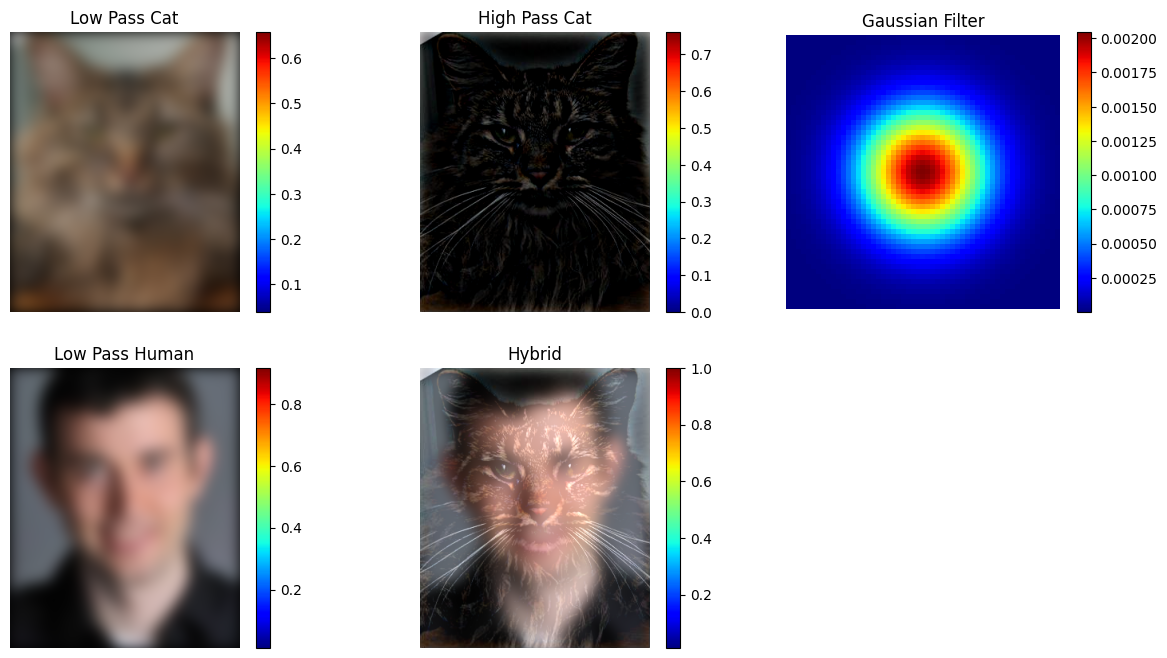

In [12]:
# Gaussian filter
sigma = 9
SZ = (6 * sigma + 1)
fil = gauss(SZ, sigma)

# Normalize cat image
cat_norm = cat/255.0

# FIND LOW PASS IMAGES
human_lp = human_c.copy()
human_lp[..., 0] = signal.convolve2d(human_c[..., 0], fil, mode='same', boundary='fill', fillvalue=0.)
human_lp[..., 1] = signal.convolve2d(human_c[..., 1], fil, mode='same', boundary='fill', fillvalue=0.)
human_lp[..., 2] = signal.convolve2d(human_c[..., 2], fil, mode='same', boundary='fill', fillvalue=0.)

cat_lp = cat_norm.copy()
cat_lp[..., 0] = signal.convolve2d(cat_norm[..., 0], fil, mode='same', boundary='fill', fillvalue=0.)
cat_lp[..., 1] = signal.convolve2d(cat_norm[..., 1], fil, mode='same', boundary='fill', fillvalue=0.)
cat_lp[..., 2] = signal.convolve2d(cat_norm[..., 2], fil, mode='same', boundary='fill', fillvalue=0.)

# FIND HP AND HYBRID IMAGE
cat_hp, hybrid = HP_HybridImage(cat_lp, cat_norm, human_lp)

######### VISUALIZATION #########
images = [cat_lp, cat_hp, fil, human_lp, hybrid]
titles = ['Low Pass Cat', 'High Pass Cat', 'Gaussian Filter', 'Low Pass Human', 'Hybrid']

plot_imgs((15, 8), 2, 3, images, titles)

As I've previously said the parameter `sigma` controls the spread of the Gaussian filter, which is the same as controlling its size. For the next part he sigma has been modified to observe its effect, with a smaller `sigma` the filter becomes more narrow and concentrated around the center, leading to less smoothing, where only nearby pixels significantly contribute to the result. How this affects the final images is that for the LP they will retain more detail and sharpness, as the blur is weaker, the HP will include more mid-frequency details because the LP filter will have retained more fine details (high frequecies), resulting in less drastic high-frequency components and, finally, the hybrid image will blend the two images more smoothly, with less distinction between LP and HP content, resulting in a less noticeable hybrid effect

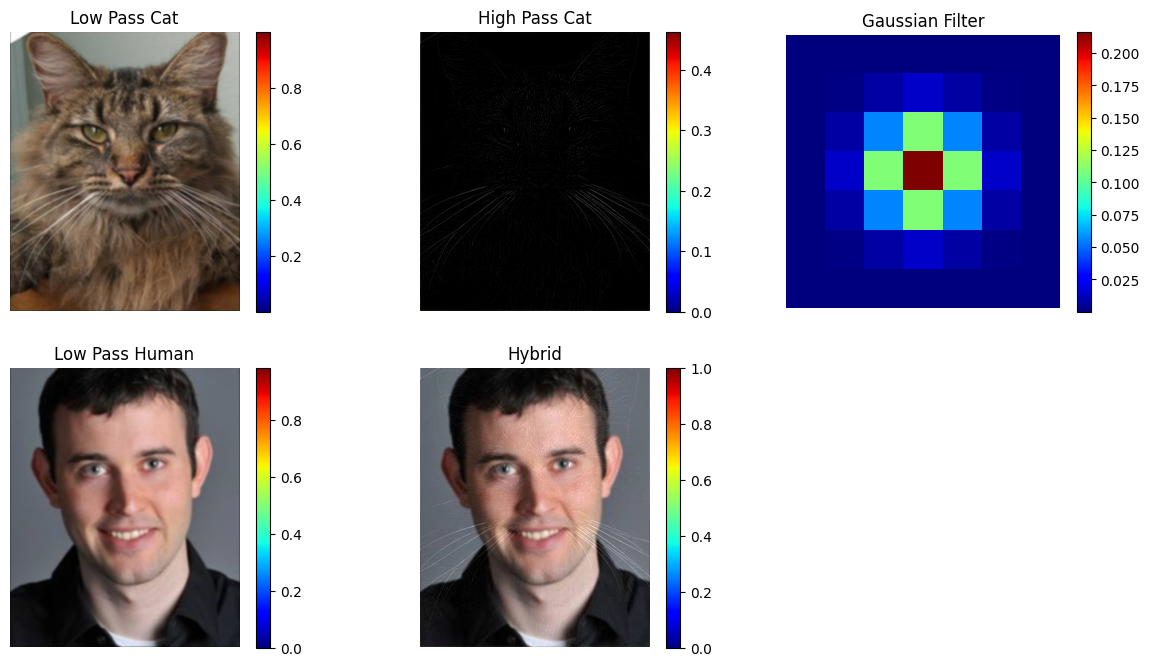

In [13]:
# Gaussian filter
sigma = 1
SZ = (6 * sigma + 1)
fil = gauss(SZ, sigma)

# Normalize cat image
cat_norm = cat/255.0

# FIND LOW PASS IMAGES
human_lp = human_c.copy()
human_lp[..., 0] = signal.convolve2d(human_c[..., 0], fil, mode='same', boundary='fill', fillvalue=0.)
human_lp[..., 1] = signal.convolve2d(human_c[..., 1], fil, mode='same', boundary='fill', fillvalue=0.)
human_lp[..., 2] = signal.convolve2d(human_c[..., 2], fil, mode='same', boundary='fill', fillvalue=0.)

cat_lp = cat_norm.copy()
cat_lp[..., 0] = signal.convolve2d(cat_norm[..., 0], fil, mode='same', boundary='fill', fillvalue=0.)
cat_lp[..., 1] = signal.convolve2d(cat_norm[..., 1], fil, mode='same', boundary='fill', fillvalue=0.)
cat_lp[..., 2] = signal.convolve2d(cat_norm[..., 2], fil, mode='same', boundary='fill', fillvalue=0.)

# FIND HP AND HYBRID IMAGE
cat_hp, hybrid = HP_HybridImage(cat_lp, cat_norm, human_lp)

######### VISUALIZATION #########
images = [cat_lp, cat_hp, fil, human_lp, hybrid]
titles = ['Low Pass Cat', 'High Pass Cat', 'Gaussian Filter', 'Low Pass Human', 'Hybrid']

plot_imgs((15, 8), 2, 3, images, titles)

To apply this process to grayscale images, the steps are the same as for color images, but using a grayscale input. First, we create the Gaussian filter, and then the images are preprocessed. The cat image is normalized, and both images are converted to grayscale using the function `rgb2gray(rgb)`, which computes a weighted sum of the color channels. The weights correspond to the relative luminance of each color, with green contributing the most, as the human eye perceives green more intensely than red or blue.

Once the images are prepared, we use the same function as before to perform the convolutions, which produce the LP images. Following this, the same process is applied to obtain the HP images and, finally, the hybrid image.

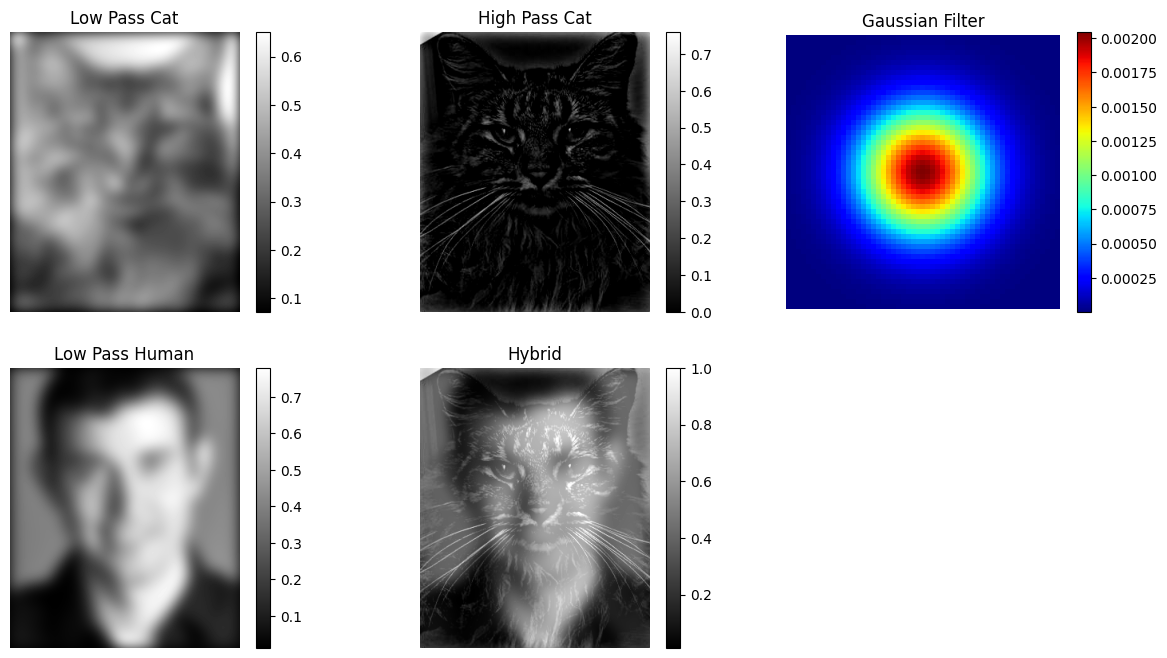

In [14]:
# Gaussian filter
sigma = 9
SZ = (6 * sigma + 1)
fil = gauss(SZ, sigma)

# Normalize cat image
cat_norm = cat/255.0

# TRANSFORM IMAGES TO GRAYSCALE
cat_gray = rgb2gray(cat_norm)
human_gray = rgb2gray(human_c)

# FIND LOW PASS IMAGES
cat_lp = signal.convolve2d(cat_gray, fil, mode='same', boundary='fill', fillvalue=0.)
human_lp = signal.convolve2d(human_gray, fil, mode='same', boundary='fill', fillvalue=0.)

# FIND HP AND HYBRID IMAGE
cat_hp, hybrid = HP_HybridImage(cat_lp, cat_gray, human_lp)

######### VISUALIZATION #########

fig = plt.figure(figsize=(15, 8))

fig.add_subplot(2, 3, 1)
plt.imshow(cat_lp, cmap="gray")
plt.title('Low Pass Cat')
plt.colorbar()
plt.axis('off')

fig.add_subplot(2, 3, 2)
plt.imshow(cat_hp, cmap="gray")
plt.title('High Pass Cat')
plt.colorbar()
plt.axis('off')

fig.add_subplot(2, 3, 3)
plt.imshow(fil, cmap="jet")
plt.title('Gaussian Filter')
plt.colorbar()
plt.axis('off')

fig.add_subplot(2, 3, 4)
plt.imshow(human_lp, cmap="gray")
plt.title('Low Pass Human')
plt.colorbar()
plt.axis('off')

fig.add_subplot(2, 3, 5)
plt.imshow(hybrid, cmap="gray")
plt.title('Hybrid')
plt.colorbar()
plt.axis('off')

plt.show()

## 2. Hybrid Image in the frequency domain

Once again, our objective is to create an hybrid image between the LP image of the human and the HP image of the cat. However, in this case, we will perform the fusion in the frequency domain, to do so we will use the Fourier transform to turn the images from their spatial domain to the frequency one. Since it also needs to be applied channel by channel I created the function `channelFiltering(channel, fil_fft, fftsize)` to handle each channel individually. This function takes three parameters: `channel` which is the channel being worked on, `fil_fft`, the Gaussian filter being used but in its frequency domain, and `fftsize`, which is the size of the FFT to be used.

To carry out the process, we need to work entirely in the frequency domain. First, the function applies a 2D Fourier transform to the image channel, converting it to the frequency domain with a size of fftsize x fftsize. Next, the Fourier transformed Gaussian filter is applied to the image by multiplying the two element-wise, which preserves the low frequencies. Finally, an inverse Fourier transform is used to convert the filtered channel back to the spatial domain. Since padding is introduced during the FFT process, the output image is cropped to return it to its original size before being returned.

In [15]:
def channelFiltering(channel, fil_fft, fftsize):
    channel_fft = fftpack.fft2(channel, (fftsize, fftsize))     # Transform channel image to frequency

    channel_fil_ftt = channel_fft * fil_fft                     # Aply filter to channel image

    channel_fil = np.real(fftpack.ifft2(channel_fil_ftt))       # Anti-transformation to turn channel image from frequency to spatial domain

    hs = int(np.floor(SZ/2.))
    channel_crop = channel_fil[hs:channel.shape[0]+hs, hs:channel.shape[1]+hs]

    return channel_crop

To use the previously defined function, we first need to determine the Gaussian filter in its frequency domain that best fits our images. As in the previous exercise, we begin by creating the filter using the `gauss(SZ, sigma)` function, which generates it in the spatial domain. To transform it into the frequency domain, we apply the `fft2(x, shape)` function, which we covered in class. The shape parameter determines the size of the final result and is set by the variable fftsize, which is given a value of 512. This value is chosen based on the image size, and we select the smallest power of two that is slightly larger than the image dimensions. In this case, the images have a shape of (352, 288, 3), so we use $2^9=512$, since $2^8=256$ would be too small.

We create LP images for the human and the cat by applying the FFT filter to each channel, using the previously defined variables (fil_fft, fftsize). For the cat image, we must first normalize it by dividing all its pixel values by their sum. Using the previously defined and explained function, `HP_HybridImage(lp_img1, original_img1, lp_img2)`, we compute the HP image of the cat and the resulting hybrid image by fusing the cat's HP image with the human's LP image.

In the final figure, six images are displayed: the LP images for both the cat and the human, the HP image of the cat, the resulting hybrid image, and the Gaussian filter used in both its spatial and frequency domain forms.

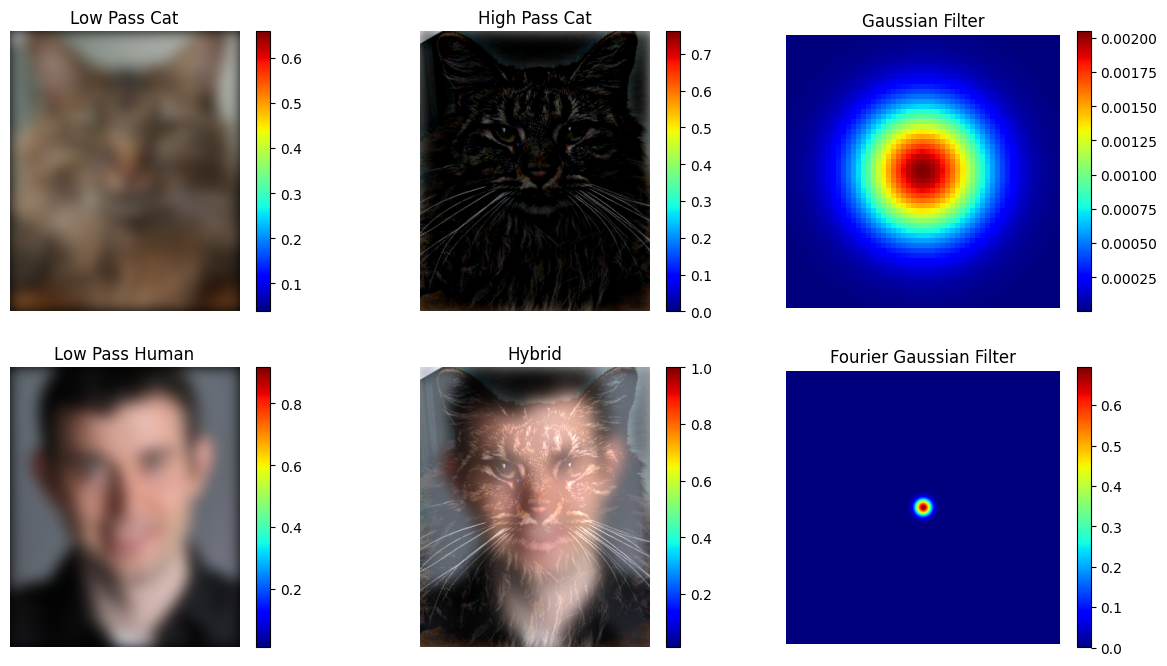

In [19]:
# Gaussian filter
sigma = 9
SZ = (6 * sigma + 1)
fil = gauss(SZ, sigma)

fftsize = 512

fil_fft = fftpack.fft2(fil, (fftsize, fftsize))             # Transform gaussian filter to frequency

# FIND LOW PASS IMAGES
human_lp = human_c.copy()
human_lp[..., 0], human_lp[..., 1], human_lp[..., 2] = channelFiltering(human_lp[..., 0], fil_fft, fftsize), channelFiltering(human_lp[..., 1], fil_fft, fftsize), channelFiltering(human_lp[..., 2], fil_fft, fftsize)

cat_norm = cat/255.0
cat_lp = cat_norm.copy()
cat_lp[..., 0], cat_lp[..., 1], cat_lp[..., 2] = channelFiltering(cat_lp[..., 0], fil_fft, fftsize), channelFiltering(cat_lp[..., 1], fil_fft, fftsize), channelFiltering(cat_lp[..., 2], fil_fft, fftsize) 

# FIND HP AND HYBRID IMAGE
cat_hp, hybrid = HP_HybridImage(cat_lp, cat_norm, human_lp)

######### VISUALIZATION #########
images = [cat_lp, cat_hp, fil, human_lp, hybrid, fftpack.fftshift(np.log(1+np.abs(fil_fft)))]
titles = ['Low Pass Cat', 'High Pass Cat', 'Gaussian Filter', 'Low Pass Human', 'Hybrid', 'Fourier Gaussian Filter']

plot_imgs((15, 8), 2, 3, images, titles)

In [17]:
print(cat_lp.min())
print(cat_lp.max())
print(cat_norm.min())
print(cat_norm.max())

0.0378403090990299
0.658444813460682
0.0
1.0
